## Overland Flow Scratchwork

First get the necessary libraries

In [1]:
import numpy as np
from matplotlib.pyplot import figure

from landlab.components import OverlandFlow

from landlab.io.esri_ascii import read_esri_ascii
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow

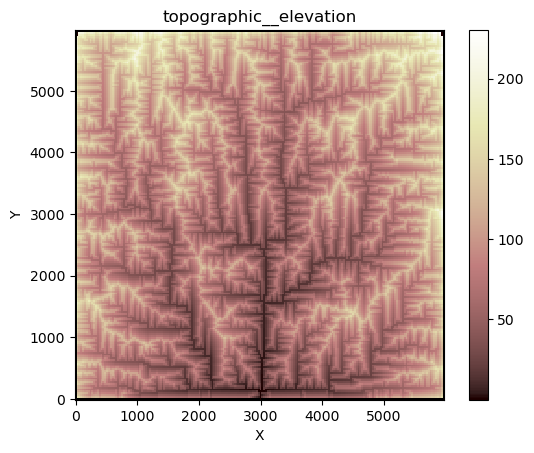

In [2]:
#read in artificially generated raster
grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

#close all boundaries
grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

#open the outlet 
#This DEM was generated using Landlab and the outlet node ID was known
my_outlet_node = 100
grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")

In [40]:
#add surface water depth (1 m everywhere)
grid.add_ones("surface_water__depth", at = "node", clobber = True)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [41]:
#now add rouughness
grid.add_zeros("rough",  at = "node", clobber=True)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [42]:
#map roughness to link
r = grid.map_mean_of_link_nodes_to_link("rough")

#add to grid
grid.add_field("mannings_n", r, at = "link", clobber=True)

#check that they are there
grid.at_link.keys()

['surface_water__depth',
 'water_surface__gradient',
 'surface_water__discharge',
 'mannings_n']

['mannings_n',
 'surface_water__depth',
 'water_surface__gradient',
 'surface_water__discharge']

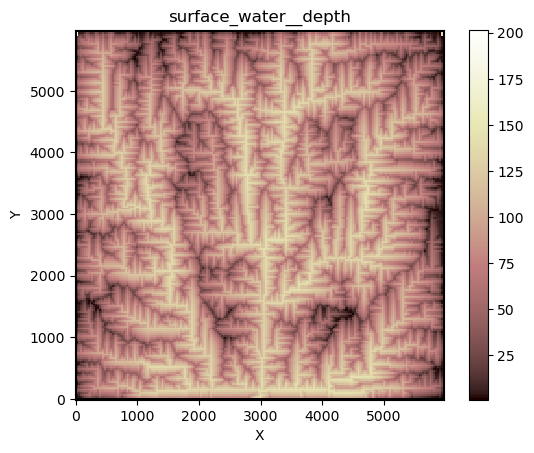

In [6]:
#init overland flow model
of = OverlandFlow(grid, mannings_n = "mannings_n", rainfall_intensity=1, steep_slopes=True)

#run model 100 steps
for i in range(100):
    of.run_one_step()

#plot water depth
figure('water depth')
imshow.imshow_grid_at_node(grid, "surface_water__depth")

grid.at_link.keys()

In [19]:
#define funcitons
def Baptist_2007(
    veg_den, veg_diam, veg_height, water_depth, 
    bed_roughness=10, drag_coef=1.0, gravity=9.81, van_karman=0.41
):
    #The baptist equation 
    Cr1=1/math.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) + (math.sqrt(gravity)/van_karman)*np.log(water_depth/veg_height)
    Cr2=1/math.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) 
    if veg_height>=water_depth:
        return Cr2
    else:
        return Cr1
        
        
def chezy_to_manning(water_depth, Chezy):
    #The actual relationship
    n=water_depth**(1/6)/Chezy
    return n
    

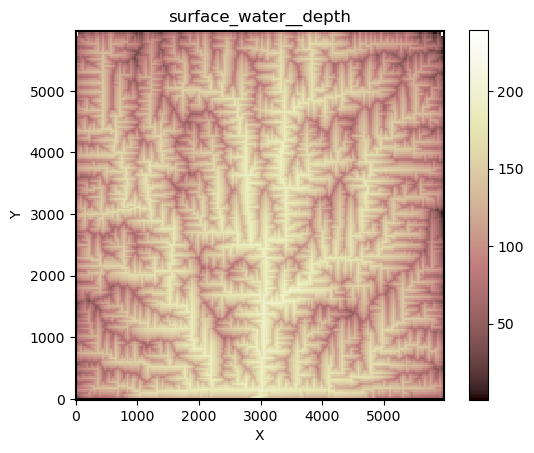

In [44]:
#init overland flow model
of_m = OverlandFlow(grid, mannings_n = "mannings_n", rainfall_intensity=1, steep_slopes=True)

#loop
for i in range(100):
    of.run_one_step()
    m_val = []
    for i in grid.at_link["surface_water__depth"]:
        b = Baptist_2007(veg_den=4500, veg_diam=0.003, veg_height=0.15, 
                         water_depth=i)
        m = chezy_to_manning(i, b)
        m_val.append(m) 
    grid.add_field("mannings_n", m_val, at = "link", clobber=True)

#plot water depth
figure('water depth')
imshow.imshow_grid_at_node(grid, "surface_water__depth")